In [1]:
#dataset -> https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?resourcekey=0-01Pth1hq20K4kuGVkp3oBw

import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
%matplotlib inline

In [4]:
IMG_SIZE = 56

In [5]:
layers = tf.keras.layers 

def build_gen_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 64)))
    model.add(layers.Conv2DTranspose(32, 3, 2, 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(16, 3, 2, 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(3, 3, 2, 'same', use_bias=False, activation='sigmoid'))
    return model

In [6]:
def build_disc_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, 3, 2, 'same', input_shape=[56, 56, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 3, 2, 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, 3, 2, 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    #model.add(layers.Lambda(tf.tanh))

    return model

In [7]:
discriminator = build_disc_model() 
generator = build_gen_model()

In [8]:
mse = tf.keras.losses.MeanSquaredError()

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = mse(tf.ones_like(real_output), real_output)
    fake_loss = mse(-tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [12]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.path = './crop_part1'
        self.imgs = os.listdir(self.path)
    
    def __len__(self):
        return len(self.imgs)//self.batch_size
    
    def __getitem__(self, idx):
        start = self.batch_size * idx
        images = np.zeros(shape=(self.batch_size, 56,56,3), dtype='float32')
        for k in range(self.batch_size):
            img = PIL.Image.open(os.path.join(self.path, self.imgs[start+k]))
            img = img.resize((56,56))
            images[k] = np.array(img)/255
        return images
    
    def on_epoch_end(self):
        np.random.shuffle(self.imgs)
    

In [13]:
BATCH_SIZE = 8
noise_dim = 100
dataset = Dataset(BATCH_SIZE)

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [78]:
epochs = 60
for epoch in range(epochs):
    steps_per_epoch = len(dataset)
    print('\n<<EPOCH {}/{}>>'.format(epoch+1, epochs))
    for i in range(steps_per_epoch):
        data = dataset[i]
        l1, l2 = train_step(data)
        if i%10 == 0:
            print('\rstep: {}/{}\t|\tGen Loss: {:.3f}\t|\tDisc Loss: {:.3f}\t\t'.format(i+1,
                                                                                        steps_per_epoch,
                                                                                        l1.numpy(),
                                                                                        l2.numpy()),
                  end='')
    print()
            
    dataset.on_epoch_end()


<<EPOCH 1/60>>
step: 1221/1222	|	Gen Loss: 3.073	|	Disc Loss: 0.534		

<<EPOCH 2/60>>
step: 1221/1222	|	Gen Loss: 2.832	|	Disc Loss: 0.680		

<<EPOCH 3/60>>
step: 1221/1222	|	Gen Loss: 2.410	|	Disc Loss: 0.555		

<<EPOCH 4/60>>
step: 1221/1222	|	Gen Loss: 2.718	|	Disc Loss: 0.740		

<<EPOCH 5/60>>
step: 1221/1222	|	Gen Loss: 3.196	|	Disc Loss: 0.363		

<<EPOCH 6/60>>
step: 1221/1222	|	Gen Loss: 3.597	|	Disc Loss: 1.179		

<<EPOCH 7/60>>
step: 1221/1222	|	Gen Loss: 3.040	|	Disc Loss: 0.632		

<<EPOCH 8/60>>
step: 1221/1222	|	Gen Loss: 2.987	|	Disc Loss: 0.451		

<<EPOCH 9/60>>
step: 1221/1222	|	Gen Loss: 2.725	|	Disc Loss: 0.563		

<<EPOCH 10/60>>
step: 1221/1222	|	Gen Loss: 2.452	|	Disc Loss: 0.611		

<<EPOCH 11/60>>
step: 1221/1222	|	Gen Loss: 2.714	|	Disc Loss: 0.611		

<<EPOCH 12/60>>
step: 1221/1222	|	Gen Loss: 2.870	|	Disc Loss: 0.794		

<<EPOCH 13/60>>
step: 1221/1222	|	Gen Loss: 3.946	|	Disc Loss: 0.595		

<<EPOCH 14/60>>
step: 1221/1222	|	Gen Loss: 2.546	|	Disc Loss: 0.689		



KeyboardInterrupt: 

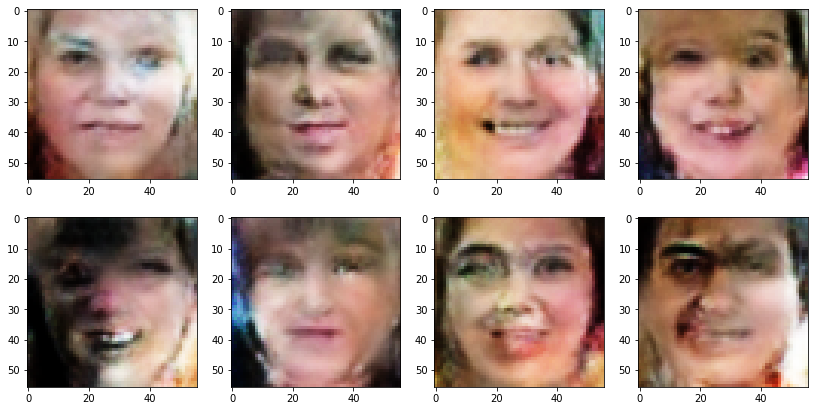

In [126]:
def gen():
    noise = tf.random.normal([1, 100])
    return generator(noise, training=0)[0].numpy()

fig, axs = plt.subplots(2, 4, figsize=(14,7))

for i in range(8):
    img = gen()
    axs[i//4][i%4].imshow(img)